> This notebook is trying to use [A Million News Headlines](https://www.kaggle.com/therohk/million-headlines) dataset to implement a fake news headlines detection model using machine learning approach. Where the A Million News Headlines dataset will be labeled as real news headlines. And this notebook will also use two fake news headline datasets on Kaggle from [Fake and real news](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset) and [Getting Real about Fake News](https://www.kaggle.com/mrisdal/fake-news) . 



In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# **Load Datasets**

In [2]:
#Read Dataset
Headlines = pd.read_csv('dataset/abcnews-date-text.csv', usecols =["headline_text"]).dropna()
Headlines1 = pd.read_csv('dataset/fake.csv', usecols =["title"]).dropna()
# Headlines2 = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv', usecols =["title"]).dropna()

In [3]:
#Removing duplicated headlines
Headlines = Headlines.drop_duplicates('headline_text')
Headlines1 = Headlines1.drop_duplicates('title')
# Headlines2 = Headlines2.drop_duplicates('title')

In [4]:
#Rename dataframe columns and Combine all datasets
Headlines1 = Headlines1.rename(columns={'title': 'headline_text'})
# Headlines2 = Headlines2.rename(columns={'title': 'headline_text'})

# **Labelling**

In [5]:
#Creating lable for datasets
#million-headlines dataset will be used as real headlines
#fake-and-real-news-dataset & fake-news dataset will be used as fake headlines
Headlines['fake'] = 0
Headlines1['fake'] = 1
# Headlines2['fake'] = 1

# **Combine Datasets**

In [6]:
#Downsize million-headlines dataset to first 50K rows
data = pd.concat([Headlines[:50000],Headlines1])
print('Training dataset contains: {} Real headlines and {} Fake headlines.'.format(50000,len(Headlines1)))
data.to_csv('Combined_headlines.csv', index=False)

Training dataset contains: 50000 Real headlines and 11698 Fake headlines.


# **Data Preprocessing**

In [7]:
import gensim
import nltk as nl
nl.download("stopwords", download_dir='./nltk_data')
nl.download("punkt", download_dir='./nltk_data')
from sklearn.feature_extraction import text


nltk_stopwords = nl.corpus.stopwords.words('english')
gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS
sklearn_stopwords = text.ENGLISH_STOP_WORDS
combined_stopwords = sklearn_stopwords.union(nltk_stopwords,gensim_stopwords)

[nltk_data] Downloading package stopwords to ./nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to ./nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
print('NLTK has {} stop words'.format(len(nltk_stopwords)))
print('Gensim has {} stop words'.format(len(gensim_stopwords)))
print('Sklearn has {} stop words'.format(len(sklearn_stopwords)))
print('Combined stopwords list has {} stop words'.format(len(combined_stopwords)))

NLTK has 179 stop words
Gensim has 337 stop words
Sklearn has 318 stop words
Combined stopwords list has 390 stop words


In [9]:
from nltk.stem import PorterStemmer 
porter_stemmer = PorterStemmer() 

In [10]:
data['headline_text'] = data['headline_text'].apply(lambda x: x.lower())
data['headline_text'] = data['headline_text'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
data['headline_text'] = data['headline_text'].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()]))
data['headline_text'] = data['headline_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (combined_stopwords)]))

# **Splitting Dataset**

In [11]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(data['headline_text'], data['fake'], test_size=0.2, random_state=7)

# **Construct models with TF-IDF**

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding, GlobalMaxPooling1D
# from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [13]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = word_tokenize, max_features = 300)
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)
tfidf_features = tfidf_vectorizer.get_feature_names_out()

c:\Users\Oscar Yu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# **1.1 Different Basic Model Overview**

**1.Decision Tree**

In [36]:
from sklearn.metrics import accuracy_score
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(tfidf_train, y_train)
y_pred_dt = dt_model.predict(tfidf_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy of the Decision Tree model: {accuracy_dt * 100:.2f}%")

Accuracy of the Decision Tree model: 85.21%


**2.Random Forest Classifier**

In [37]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_model.fit(tfidf_train, y_train)
y_pred_rf = rf_model.predict(tfidf_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of the Random Forest model: {accuracy_rf * 100:.2f}%")

Accuracy of the Random Forest model: 81.27%


**3.k-Nearest Neighbors (kNN)**

In [38]:

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(tfidf_train, y_train)
y_pred = knn_model.predict(tfidf_test)
accuracy_kNN = accuracy_score(y_test, y_pred)
print(f"Accuracy of the kNN model: {accuracy_kNN * 100:.2f}%")

Accuracy of the kNN model: 80.23%


**4.Support Vector Classifier (SVC)**

In [39]:
from sklearn.svm import SVC
svc_model = SVC(kernel='linear', C=1, random_state=42)
svc_model.fit(tfidf_train, y_train)
y_pred = svc_model.predict(tfidf_test)
accuracy_SVC = accuracy_score(y_test, y_pred)
print(f"Accuracy of the SVC model: {accuracy_SVC * 100:.2f}%")

Accuracy of the SVC model: 87.63%


**5.Naive Bayesiian Model**

In [40]:
nb_model = MultinomialNB()
nb_model.fit(tfidf_train, y_train)
y_pred = nb_model.predict(tfidf_test)
accuracy_nb = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Naive Bayes model: {accuracy_nb * 100:.2f}%")


Accuracy of the Naive Bayes model: 88.03%


In [ ]:
tfidf_train = tfidf_train.todense()
tfidf_test = tfidf_test.todense()

neural_network = Sequential()
neural_network.add(Dense(64, input_dim=len(tfidf_features), activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(64, activation='relu'))
neural_network.add(Dropout(0.1))
neural_network.add(Dense(1, activation='sigmoid'))
neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = neural_network.fit(tfidf_train, y_train, epochs=50, batch_size=512, verbose=0)
_,test_acc = neural_network.evaluate(tfidf_test,y_test,verbose=0)
print ("Testing Acc. of DNN: {} %".format(round(test_acc * 100, 2)))

C:\Users\borisPMC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing Acc. of DNN: 88.2 %


**6.Logistic Regression Model**

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Logistic Regression Model
log_reg = LogisticRegression(C=1.0, penalty='none', solver='newton-cg', random_state=42)

# Train the model
log_reg.fit(tfidf_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(tfidf_test)

# Evaluate the model
accuracy_log = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_log:.2f}")
print(classification_report(y_test, y_pred))

c:\Users\Oscar Yu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      9997
           1       0.87      0.44      0.58      2343

    accuracy                           0.88     12340
   macro avg       0.87      0.71      0.76     12340
weighted avg       0.88      0.88      0.86     12340



**Basic Model Performance Summary**

In [55]:
print("\nModel Performance Summary:")
print(f"{'Model':<20} {'Accuracy':>10}")
print("-" * 30)
print(f"{'Decision Tree:':<25}{accuracy_dt * 100:.2f}%")
print(f"{'Random Forest:':<24} {accuracy_rf * 100:.2f}%")
print(f"{'kNN:':<24} {accuracy_kNN * 100:.2f}%")
print(f"{'SVC:':<24} {accuracy_SVC * 100:.2f}%")
print(f"{'Naive Bayes:':<24} {accuracy_nb * 100:.2f}%")
print(f"{'Logistic Regression:':<24} {accuracy_log * 100:.2f}%")


Model Performance Summary:
Model                  Accuracy
------------------------------
Decision Tree:           85.21%
Random Forest:           81.27%
kNN:                     80.23%
SVC:                     87.63%
Naive Bayes:             88.03%
Logistic Regression:     88.03%


# **1.2Random Sampling from TFIDF_train (with label) set with different models**

In [44]:
def get_random_sample_sets(df: pd.DataFrame, n=100, k=5000):

    # df must contain both train and test set, with y labels

    def get_class(label):
        df_found = df[df["fake" == label]]
        df_sample = df_found.sample(k)
        return df_sample
    
    def get_balanced_set():
        true_set = get_class(0)
        fake_set = get_class(1)
        combine_set = pd.concat((true_set, fake_set), axis=0)
        shuffle_set = combine_set.sample(frac=1)
        return shuffle_set
    
    sample_sets = [get_balanced_set() for _ in range(n)]
    return sample_sets

def bagging_pred(model_set, test_set: pd.DataFrame):

    def model_pred(model: DecisionTreeClassifier, test_set: pd.DataFrame):
        y_pred = model.predict(test_set)
        return y_pred
    
    def vote(row: pd.Series):
        vote_result = row.mode()[0]  # Ensure to get the first mode if there are multiple modes
        return vote_result

    Y = test_set["fake"]
    X = test_set.drop("fake", axis=1)

    predictions = []
    # Collect predictions in a list. Iterated by models
    for k in range(len(model_set)):
        pred = model_pred(model_set[k], X)
        predictions.append(pred)

    pred_result = pd.DataFrame(predictions)

    # Apply the voting function to each row to get a Series
    vote_result_series = pred_result.apply(vote, axis=1)
    
    # Now, vote_result_series is a Series where each element is the vote result for a single row
    score = accuracy_score(Y, vote_result_series)
    print(score)

test_df = pd.concat((pd.DataFrame(tfidf_test.toarray()), y_test.reset_index(drop=True)), axis=1)


[                                                feature  label
0       (0, 197)\t0.7118090525324496\n  (0, 55)\t0.7...      0
1       (0, 99)\t0.7728055187846891\n  (0, 16)\t0.63...      1
2                                                            1
3                                         (0, 103)\t1.0      1
4       (0, 150)\t0.7432673484394656\n  (0, 109)\t0....      0
...                                                 ...    ...
1995                                       (0, 40)\t1.0      0
1996                                       (0, 38)\t1.0      0
1997                                       (0, 44)\t1.0      0
1998    (0, 159)\t0.6217835149139983\n  (0, 66)\t0.6...      1
1999    (0, 159)\t0.5107424215655427\n  (0, 157)\t0....      1

[2000 rows x 2 columns],                                                 feature  label
0                                          (0, 82)\t1.0      1
1                                          (0, 55)\t1.0      0
2                           

# **2.1 Create a confusion matrix graph with PCA and logistic Regression**

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      9997
           1       0.90      0.30      0.45      2343

    accuracy                           0.86     12340
   macro avg       0.88      0.65      0.69     12340
weighted avg       0.87      0.86      0.83     12340



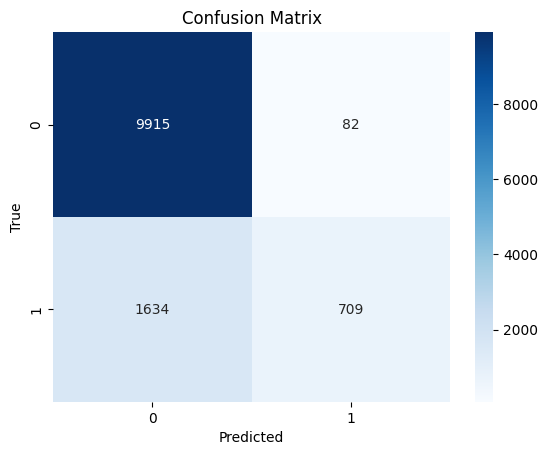

Cross-validation scores: [0.86223663 0.85767828 0.8572731  0.85654949 0.85898085]
Average cross-validation score: 0.8585436695774191


In [14]:
# Create a pipeline with PCA and logistic regression
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


# Convert sparse matrix to dense array
tfidf_train_dense = tfidf_train.toarray()
tfidf_test_dense = tfidf_test.toarray()
# Define the pipeline
pipeline = Pipeline([
    ('pca', PCA(n_components=10)),  # Adjust n_components based on your data
    ('logistic_regression', LogisticRegression(random_state=42))
])

# Fit the pipeline
pipeline.fit(tfidf_train_dense, y_train)

# Predict on the test set
predictions = pipeline.predict(tfidf_test_dense)

# Print classification report
print(classification_report(y_test, predictions))  # Corrected to use y_test

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Perform 5-fold cross-validation
scores = cross_val_score(pipeline, tfidf_train_dense, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {np.mean(scores)}")

*Create a pipeline with PCA and Logistic Regression* 

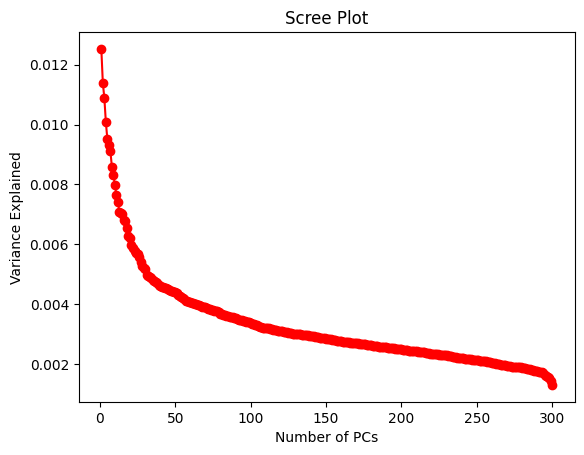

In [15]:
# Create a pipeline with PCA and logistic regression
pc_num = 300

pipe = Pipeline([
    ('pca', PCA(n_components = pc_num)), # choose number of components to keep
    ('clf', LogisticRegression(solver = 'liblinear', class_weight = 'balanced', max_iter = 500, penalty = 'l1'))
])

pipe.fit(tfidf_train_dense, y_train)

# Create a scree plota
plt.plot(np.arange(1, pipe.named_steps['pca'].n_components_+1),pipe.named_steps['pca'].explained_variance_ratio_, 'ro-')
plt.xlabel('Number of PCs')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

# **2.2 Logistic Regression with Lasso**

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf_lasso = LogisticRegression(C=0.1, class_weight='balanced', penalty='l1', solver='liblinear', random_state=42)
log_clf_lasso.fit(tfidf_train, y_train)
# Corrected instantiation using keyword arguments
""" lasso_RFE_selector = RFE(estimator=log_clf_lasso, n_features_to_select=30)

lasso_RFE_selector.fit(tfidf_train, y_train) """

# Assuming you meant to use cross_val_score with the selector
scores = cross_val_score(log_clf_lasso, tfidf_train, y_train, cv=5)

print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())


Cross-validation scores: [0.86659238 0.85828606 0.84805511 0.8581704  0.85735994]
Average cross-validation score: 0.8576927781673704


# **3.1 RandomForest Classifier- Basic Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(tfidf_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(tfidf_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))


# **3.2 RandomForest Classifier- Randomized Search**

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the hyperparameter distributions
param_dist = {
    'n_estimators': randint(10, 100),
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest model
rf = RandomForestClassifier()

# Set up RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50, # Number of parameter settings that are sampled
    cv=5, # Number of cross-validation folds
    verbose=2, # Controls the verbosity: the higher, the more messages
    random_state=42, # For reproducibility
    n_jobs=-1 # Use all processors
)

# Fit the model to the data
rand_search.fit(tfidf_train, y_train)

# Access the best model and its hyperparameters
best_rf = rand_search.best_estimator_
print('Best hyperparameters:', rand_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Oscar Yu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
29 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Oscar Yu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Oscar Yu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Oscar Yu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklear

Best hyperparameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 56}


# **3.3 RandomForest Classifier- Grid Search**

In [31]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(tfidf_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(f"Best Parameters: {best_params}")

# Predict on the test set
y_pred = grid_search.predict(tfidf_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


KeyboardInterrupt: 